In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

### 1. Load Cleaned Dataset

In [2]:
df = pd.read_csv('data/Cleaned_student_data.csv')
print(f"Dataset shape: {df.shape}")
df.head(5)

Dataset shape: (6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


### 2. Feature Engineering

In [3]:
X = df.drop(columns=['Exam_Score'])
y = df['Exam_Score']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# One-hot encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {categorical_cols}")

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"\nFeatures after encoding: {X_encoded.shape}")
print(f"Feature names: {X_encoded.columns.tolist()}")

Features shape: (6607, 19)
Target shape: (6607,)

Categorical columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']

Features after encoding: (6607, 27)
Feature names: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_Yes', 'Motivation_Level_Low', 'Motivation_Level_Medium', 'Internet_Access_Yes', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_Low', 'Teacher_Quality_Medium', 'School_Type_Public', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_Yes', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgradua

### 3. Train-Test Data Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")



Training set: 5285 samples
Testing set: 1322 samples


### 4. Feature Scaling

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 5. Training Linear Regression Model

In [6]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{model_name} - {dataset_type} Set:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    
    return {'Model': model_name, 'Dataset': dataset_type, 'R2': r2, 'RMSE': rmse, 'MAE': mae}

results = []
results.append(evaluate_model(y_train, y_train_pred_lr, "Linear Regression", "Train"))
results.append(evaluate_model(y_test, y_test_pred_lr, "Linear Regression", "Test"))



Linear Regression - Train Set:
  R² Score: 0.7173
  RMSE: 2.0852
  MAE: 0.4985

Linear Regression - Test Set:
  R² Score: 0.7696
  RMSE: 1.8044
  MAE: 0.4524


### 6. Feature Importance


Top 10 Most Important Features:
                        Feature  Coefficient
1                    Attendance     2.290405
0                 Hours_Studied     1.756881
8       Access_to_Resources_Low    -0.838966
6      Parental_Involvement_Low    -0.804623
3               Previous_Scores     0.705908
4             Tutoring_Sessions     0.626224
14            Family_Income_Low    -0.544276
7   Parental_Involvement_Medium    -0.534638
20      Peer_Influence_Positive     0.516698
9    Access_to_Resources_Medium    -0.515775


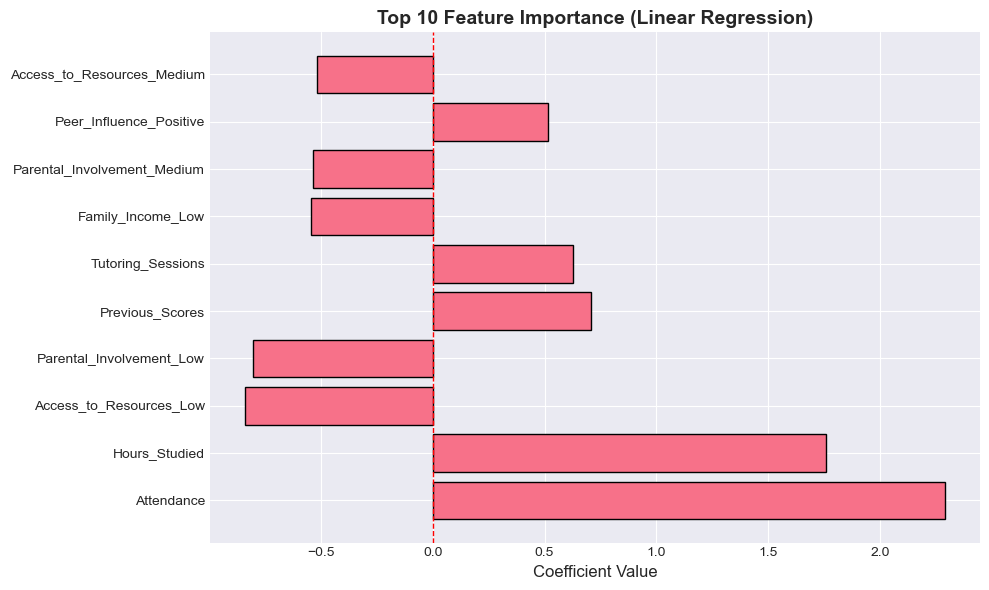

In [7]:
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Coefficient'], edgecolor='black')
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 10 Feature Importance (Linear Regression)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

### 7. Training Ploynomial Regression (degree 2)

In [8]:
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly2 = poly2.fit_transform(X_train_scaled)
X_test_poly2 = poly2.transform(X_test_scaled)

print(f"\nOriginal features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly2.shape[1]}")

poly2_model = LinearRegression()
poly2_model.fit(X_train_poly2, y_train)

y_train_pred_poly2 = poly2_model.predict(X_train_poly2)
y_test_pred_poly2 = poly2_model.predict(X_test_poly2)

results.append(evaluate_model(y_train, y_train_pred_poly2, "Polynomial Reg (deg 2)", "Train"))
results.append(evaluate_model(y_test, y_test_pred_poly2, "Polynomial Reg (deg 2)", "Test"))



Original features: 27
Polynomial features: 405

Polynomial Reg (deg 2) - Train Set:
  R² Score: 0.7374
  RMSE: 2.0098
  MAE: 0.6654

Polynomial Reg (deg 2) - Test Set:
  R² Score: 0.7471
  RMSE: 1.8906
  MAE: 0.6417


### 8. Training Ploynomial Regression (degree 3)

In [9]:
poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly3 = poly3.fit_transform(X_train_scaled)
X_test_poly3 = poly3.transform(X_test_scaled)

print(f"\nOriginal features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly3.shape[1]}")

poly3_model = LinearRegression()
poly3_model.fit(X_train_poly3, y_train)

y_train_pred_poly3 = poly3_model.predict(X_train_poly3)
y_test_pred_poly3 = poly3_model.predict(X_test_poly3)

results.append(evaluate_model(y_train, y_train_pred_poly3, "Polynomial Reg (deg 3)", "Train"))
results.append(evaluate_model(y_test, y_test_pred_poly3, "Polynomial Reg (deg 3)", "Test"))


Original features: 27
Polynomial features: 4059

Polynomial Reg (deg 3) - Train Set:
  R² Score: 0.9012
  RMSE: 1.2327
  MAE: 0.7582

Polynomial Reg (deg 3) - Test Set:
  R² Score: -0.0435
  RMSE: 3.8405
  MAE: 2.4702


### 9. Model Comparision


                  Model Dataset        R2     RMSE      MAE
     Linear Regression   Train  0.717314 2.085182 0.498451
     Linear Regression    Test  0.769650 1.804445 0.452392
Polynomial Reg (deg 2)   Train  0.737385 2.009795 0.665380
Polynomial Reg (deg 2)    Test  0.747121 1.890627 0.641666
Polynomial Reg (deg 3)   Train  0.901213 1.232655 0.758157
Polynomial Reg (deg 3)    Test -0.043470 3.840511 2.470217


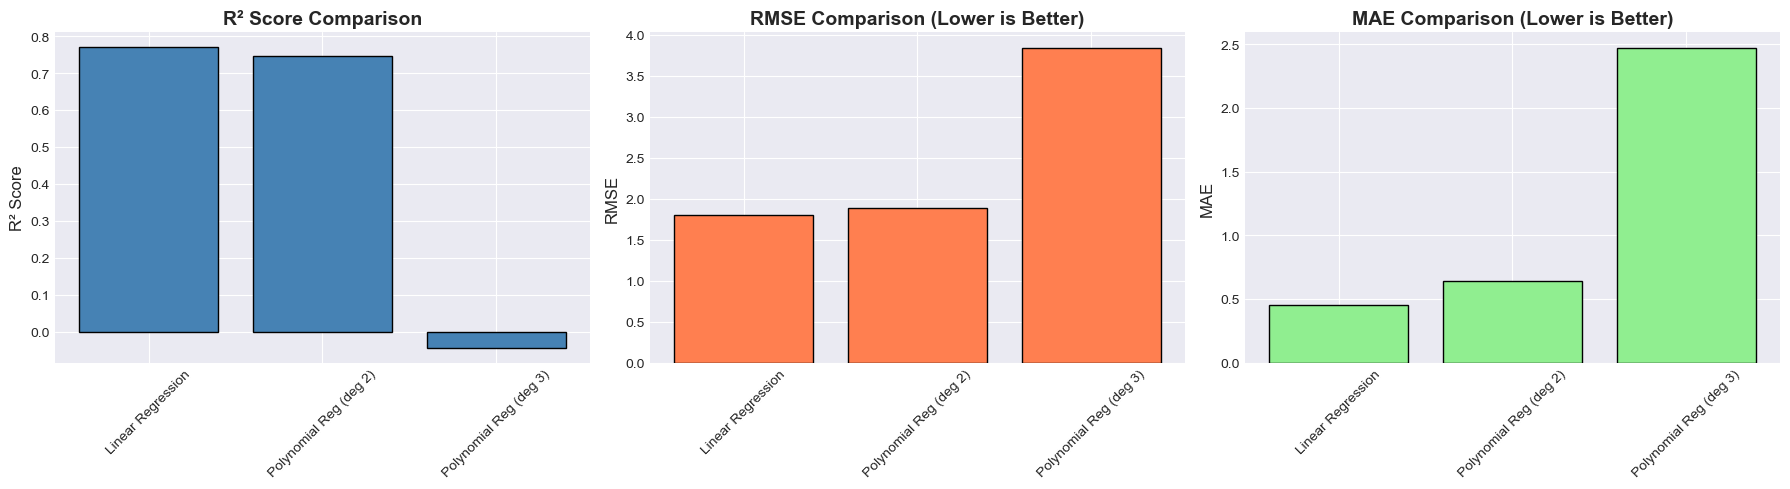

In [10]:
results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))

# Visualize comparison
test_results = results_df[results_df['Dataset'] == 'Test']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(test_results['Model'], test_results['R2'], edgecolor='black', color='steelblue')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(test_results['Model'], test_results['RMSE'], edgecolor='black', color='coral')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(test_results['Model'], test_results['MAE'], edgecolor='black', color='lightgreen')
axes[2].set_ylabel('MAE', fontsize=12)
axes[2].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 10. Actual vs Predicted Values

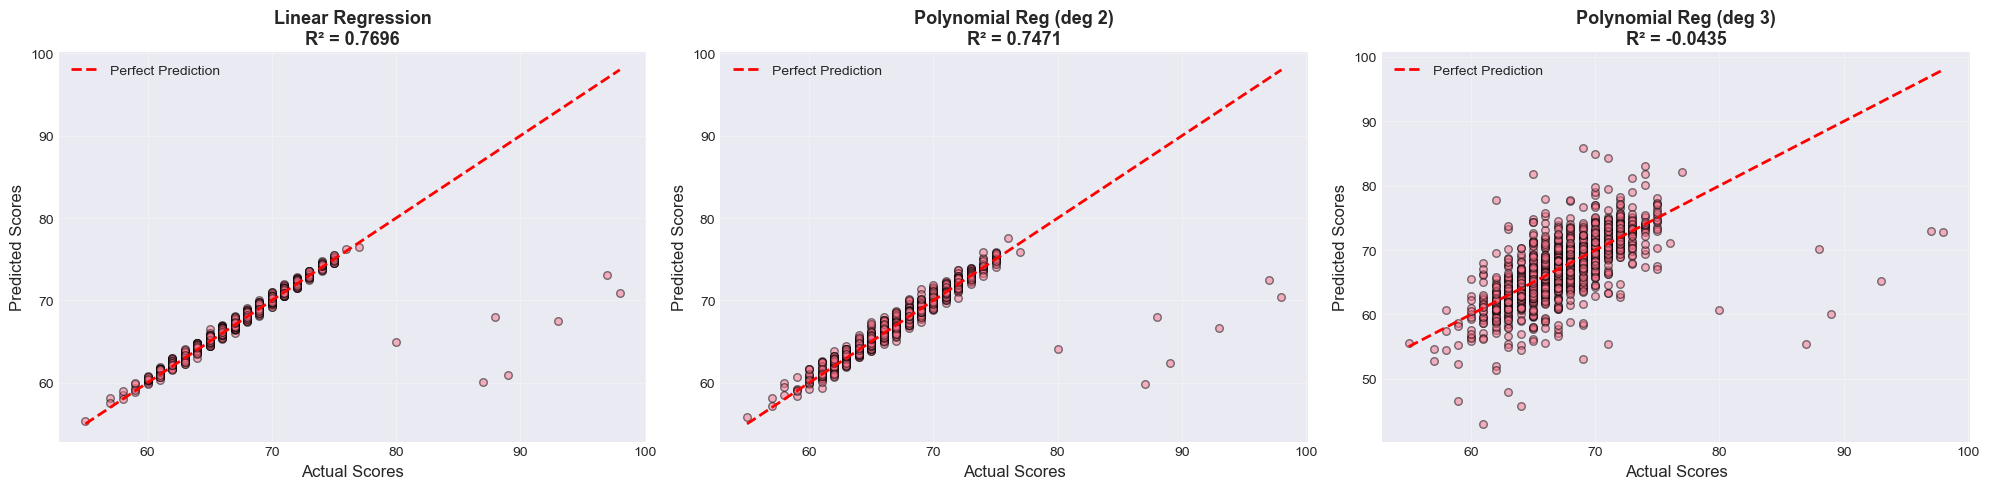

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

models_data = [
    (y_test, y_test_pred_lr, "Linear Regression"),
    (y_test, y_test_pred_poly2, "Polynomial Reg (deg 2)"),
    (y_test, y_test_pred_poly3, "Polynomial Reg (deg 3)")
]

for idx, (y_true, y_pred, title) in enumerate(models_data):
    axes[idx].scatter(y_true, y_pred, alpha=0.5, edgecolor='black', s=30)
    axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Scores', fontsize=12)
    axes[idx].set_ylabel('Predicted Scores', fontsize=12)
    axes[idx].set_title(f'{title}\nR² = {r2_score(y_true, y_pred):.4f}', fontsize=13, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 11. Residual Analysis

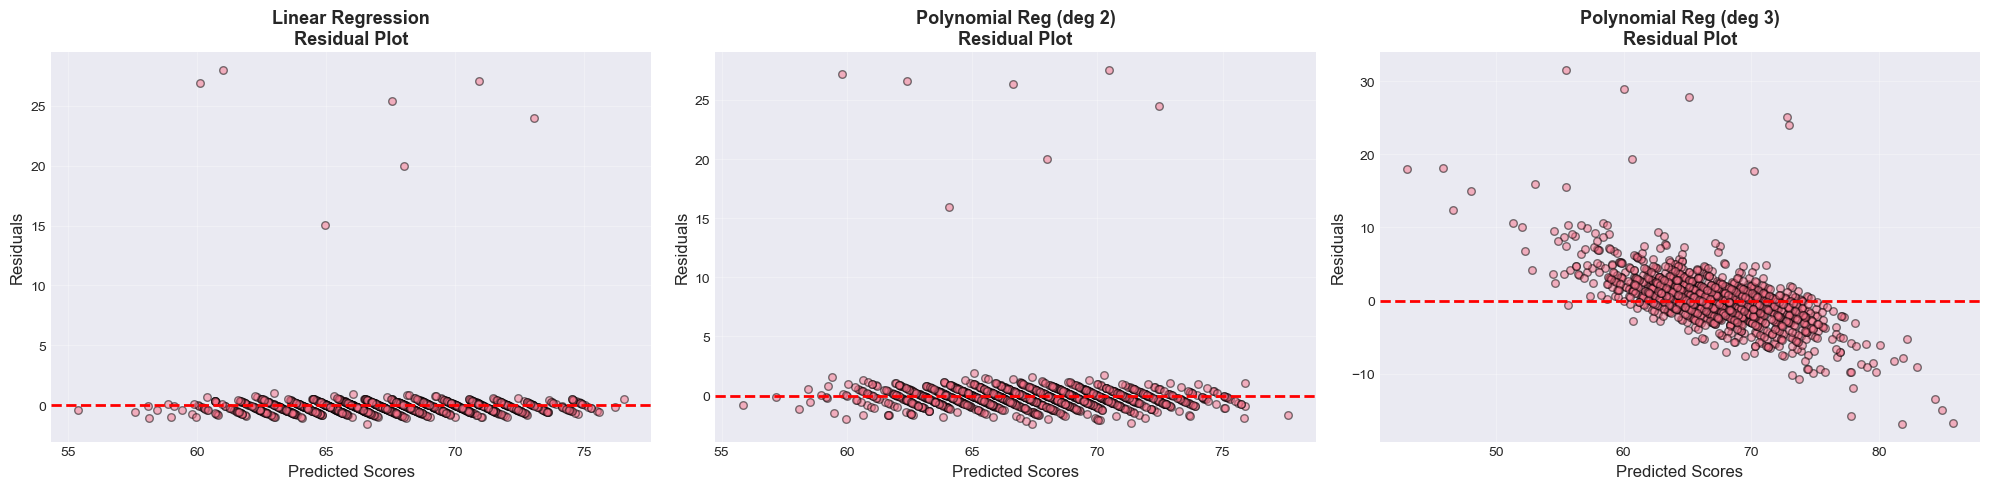

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, (y_true, y_pred, title) in enumerate(models_data):
    residuals = y_true - y_pred
    axes[idx].scatter(y_pred, residuals, alpha=0.5, edgecolor='black', s=30)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Scores', fontsize=12)
    axes[idx].set_ylabel('Residuals', fontsize=12)
    axes[idx].set_title(f'{title}\nResidual Plot', fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 12. Cross Validation

In [13]:
cv_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_poly2 = cross_val_score(poly2_model, X_train_poly2, y_train, cv=5, scoring='r2')
cv_poly3 = cross_val_score(poly3_model, X_train_poly3, y_train, cv=5, scoring='r2')

print(f"\nLinear Regression: {cv_lr.mean():.4f} (+/- {cv_lr.std():.4f})")
print(f"Polynomial Reg (deg 2): {cv_poly2.mean():.4f} (+/- {cv_poly2.std():.4f})")
print(f"Polynomial Reg (deg 3): {cv_poly3.mean():.4f} (+/- {cv_poly3.std():.4f})")


Linear Regression: 0.7232 (+/- 0.0878)
Polynomial Reg (deg 2): 0.6886 (+/- 0.0847)
Polynomial Reg (deg 3): -4.9555 (+/- 3.0071)


### 13. Select Best Model

In [14]:
best_model_row = test_results.loc[test_results['R2'].idxmax()]
print("BEST MODEL SELECTION")
print(f"\nBest Model: {best_model_row['Model']}")
print(f"Test R² Score: {best_model_row['R2']:.4f}")
print(f"Test RMSE: {best_model_row['RMSE']:.4f}")
print(f"Test MAE: {best_model_row['MAE']:.4f}")


BEST MODEL SELECTION

Best Model: Linear Regression
Test R² Score: 0.7696
Test RMSE: 1.8044
Test MAE: 0.4524


### 14. Save best Model

In [15]:
best_model = lr_model  # Change to poly2_model or poly3_model if they perform better

joblib.dump(best_model, 'models/best_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(X_encoded.columns.tolist(), 'models/feature_names.pkl')



['models/feature_names.pkl']

### Summary

In [16]:
print(f"\n📊 Dataset: {len(df)} students")
print(f"📈 Features: {X_encoded.shape[1]} (after encoding)")
print(f"🎯 Target: Exam_Score (Range: {y.min()}-{y.max()})")
print(f"\n🏆 Best Model: {best_model_row['Model']}")
print(f"   • R² Score: {best_model_row['R2']:.4f}")
print(f"   • RMSE: {best_model_row['RMSE']:.4f}")
print(f"   • MAE: {best_model_row['MAE']:.4f}")
print(f"\n🔑 Top 3 Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Coefficient']:.4f}")
print("\n✅ Ready for Streamlit deployment!")



📊 Dataset: 6607 students
📈 Features: 27 (after encoding)
🎯 Target: Exam_Score (Range: 55-101)

🏆 Best Model: Linear Regression
   • R² Score: 0.7696
   • RMSE: 1.8044
   • MAE: 0.4524

🔑 Top 3 Important Features:
   2. Attendance: 2.2904
   1. Hours_Studied: 1.7569
   9. Access_to_Resources_Low: -0.8390

✅ Ready for Streamlit deployment!
